# Supervised Machine Learning: Regression and Classification

In [19]:
import sys
sys.path.insert(0, './work/machine_learning/01 - supervised_ml_regression_classification')

import matplotlib.pyplot as plt

from pyspark.sql import SparkSession
from pyspark.sql.functions import regexp_replace, unix_timestamp, col, regexp_replace
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.stat import Correlation
import pyspark.pandas as ps
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml import Pipeline

import numpy as np
import math

## Pyspark config

In [3]:
# SPAWN A SPARKSESSION
spark = SparkSession.\
        builder.\
        appName("pyspark-notebook").\
        master("spark://spark-master:7077").\
        config("spark.executor.cores", "12").\
        config("spark.executor.memory", "1024mb").\
        getOrCreate()

In [104]:
# Read dataset for this course and cache() it

df = ps.read_csv("hdfs://namenode:9000/data/cardio_base.csv", index_col="id")
df = df.astype(int)

df = ps.get_dummies(df, columns=['gender', 'smoke'], dtype='int', )

df = df.loc[df['ap_hi'] < 500]

# Why cache dataframe?
# Reusing Data: Caching is optimal when you need to perform multiple operations on the same dataset to 
#    avoid reading from storage repeatedly.
# Frequent Subset Access: Useful for frequently accessing small subsets of a large dataset, reducing the 
#    need to load the entire dataset repeatedly.
df_cached = df.spark.cache()

df_cached.head(10)

,age,height,weight,ap_hi,ap_lo,cholesterol,gender_1,gender_2,smoke_0,smoke_1
id,,,,,,,,,,
0,18393,168,62,110,80,1,0,1,1,0
1,20228,156,85,140,90,3,1,0,1,0
2,18857,165,64,130,70,3,1,0,1,0
3,17623,169,82,150,100,1,0,1,1,0
4,17474,156,56,100,60,1,1,0,1,0
8,21914,151,67,120,80,2,1,0,1,0
9,22113,157,93,130,80,3,1,0,1,0
12,22584,178,95,130,90,3,0,1,1,0
13,17668,158,71,110,70,1,1,0,1,0


## Week 2

### Logistic Regression

$
\text{Repeat until convergence } \{ 
\\
w_j = w_j - \alpha \frac{1}{m} \sum_{i=0}^{m-1} ((f_{\vec{w},b}(x^{(i)}) - y^{(i)}) \cdot x_j^{(i)})
\\
 b := b - \alpha \frac{1}{m} \sum\limits_{i=0}^{m-1} (f_{\vec{w},b}(x^{(i)}) - y^{(i)}) 
\\
\}
$



##### Implementation of Multiple Linear Regression w/ MinMaxScaling in Spark using pyspark.pandas API

In [148]:
# LINEAR REGRESSION AGE IN DAYS AND WEIGHT TO PREDICT SYSTOLIC BLOOD PRESSURE
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import RegressionEvaluator

sampled_df = df_cached.sample(frac=0.9)

# Convert pandas dataframe to Spark dataframe
spark_df = sampled_df.to_spark()

# Split the data into a training and test set
train_ratio = 0.8
test_ratio = 1 - train_ratio

train_df, test_df = spark_df.randomSplit([train_ratio, test_ratio], seed=42)

/usr/local/spark/python/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `to_spark`, the existing index is lost when converting to Spark DataFrame.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


In [150]:

# Create the scaler object
columns_to_scale = ["height"]
assemblers = [VectorAssembler(inputCols=[col], outputCol=col + "_vec") for col in columns_to_scale]
scalers = [MinMaxScaler(inputCol=col + "_vec", outputCol=col + "_scaled") for col in columns_to_scale]
pipeline = Pipeline(stages=assemblers + scalers)
scalers_model = pipeline.fit(train_df)
scaled_train_df = scalers_model.transform(train_df)
scaled_test_df = scalers_model.transform(test_df)

assembler = VectorAssembler(inputCols=["height_scaled"], outputCol="features")
assembled_scaled_train_df = assembler.transform(scaled_train_df)
assembled_scaled_test_df = assembler.transform(scaled_test_df)

# Show the scaled DataFrame
assembled_scaled_train_df.show(10)

+-----+------+------+-----+-----+-----------+--------+--------+-------+-------+----------+--------------------+--------------------+
|  age|height|weight|ap_hi|ap_lo|cholesterol|gender_1|gender_2|smoke_0|smoke_1|height_vec|       height_scaled|            features|
+-----+------+------+-----+-----+-----------+--------+--------+-------+-------+----------+--------------------+--------------------+
|10798|   175|    92|  100|   60|          1|       0|       1|      1|      0|   [175.0]|[0.6153846153846154]|[0.6153846153846154]|
|10859|   159|    59|  120|   80|          1|       1|       0|      1|      0|   [159.0]|[0.5333333333333333]|[0.5333333333333333]|
|10964|   160|    59|  110|   70|          1|       1|       0|      1|      0|   [160.0]|[0.5384615384615384]|[0.5384615384615384]|
|14275|   164|   105|  150|  110|          3|       1|       0|      1|      0|   [164.0]| [0.558974358974359]| [0.558974358974359]|
|14277|   168|   109|  150|  100|          1|       0|       1|      

In [151]:
# Create a Linear Regression model
lr = LogisticRegression(featuresCol="features", labelCol="gender_1")

# Fit the model to the data
lr_model = lr.fit(assembled_scaled_train_df)

#print("Coefficients: %s" % str(lr_model.coefficients))
#print("Intercept: %s" % str(lr_model.intercept))
#
pred = lr_model.transform(assembled_scaled_test_df)
#pred.show(10)
#
## Create a RegressionEvaluator object
evaluator = MulticlassClassificationEvaluator(labelCol="gender_1", predictionCol="prediction")
#
#
## Calculate areaUnderROC
a_roc = evaluator.evaluate(pred, {evaluator.metricName: "accuracy"})
#
## Calculate MSE
#mse = evaluator.evaluate(pred, {evaluator.metricName: "mse"})
#
## Calculate MAE
#mae = evaluator.evaluate(pred, {evaluator.metricName: "mae"})
#
## Calculate R2
#r2 = evaluator.evaluate(pred, {evaluator.metricName: "r2"})
#
print("accuracy:", a_roc)
#print("MSE:", mse)
#print("MAE:", mae)
#print("R2:", r2)

accuracy: 0.7671340173885799


Reverted Coefficients: [-0.19184424248498938]
Reverted Bias: 32.40528816895259


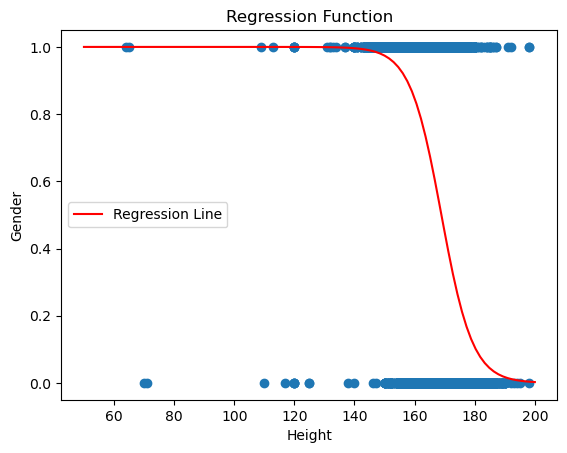

In [156]:
# Get the coefficients and bias from lr_model
coefficients = [lr_model.coefficients[0]] * 100

bias = lr_model.intercept

# Define the x values for the regression line
x = np.linspace(50, 200, 100)

# Calculate the y values for the regression line
def logistic_regression(x, coefficients, bias):
    z = (coefficients * x) + bias
    return 1 / (1 + np.exp(-z))

# Get the scaling parameters from the scalers_model
scaling_params = scalers_model.stages[-1].originalMin.toArray(), scalers_model.stages[-1].originalMax.toArray()
reverted_coefficients = lr_model.coefficients / (scaling_params[1] - scaling_params[0])
reverted_bias = lr_model.intercept - np.dot(reverted_coefficients, scaling_params[0])

y = logistic_regression(x, reverted_coefficients, reverted_bias)


# Revert the bias
#reverted_bias = lr_model.intercept - np.dot(reverted_coefficients, scaling_params[0])

# Print the reverted coefficients and bias
print("Reverted Coefficients:", reverted_coefficients)
print("Reverted Bias:", reverted_bias)

plt.scatter(assembled_scaled_test_df.select('height').collect(), assembled_scaled_test_df.select('gender_1').collect())

# Plot the regression line
plt.plot(x, y, color='red', label='Regression Line')
plt.xlabel('Height')
plt.ylabel('Gender')
plt.title('Regression Function')
plt.legend()
plt.show()


In [174]:
z

168.9145723072096

The decision boundary is at 168.9145723072096 centimeters


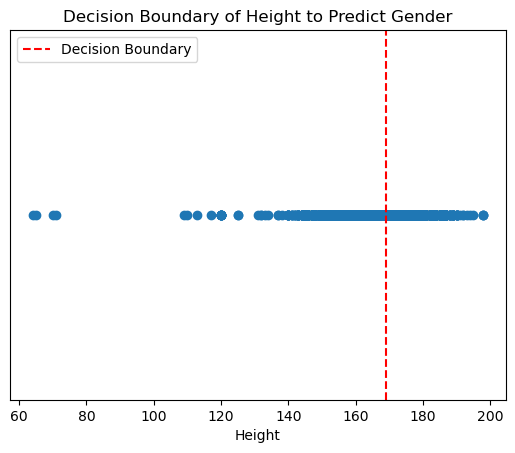

In [184]:
# Plot the actual data points
import numpy as np

heights = assembled_scaled_test_df.select('height').collect()
z = -reverted_bias / reverted_coefficients[0]

print(f"The decision boundary is at {z} centimeters")
fig, ax = plt.subplots(1)

ax.scatter(heights, np.zeros(len(heights)))
ax.axvline(x=z, color='red', linestyle='--', label='Decision Boundary')
ax.set_yticks([])
plt.xlabel('Height')
plt.ylabel('')
plt.title('Decision Boundary of Height to Predict Gender')


# Show the legend
plt.legend()

# Show the plot
plt.show()


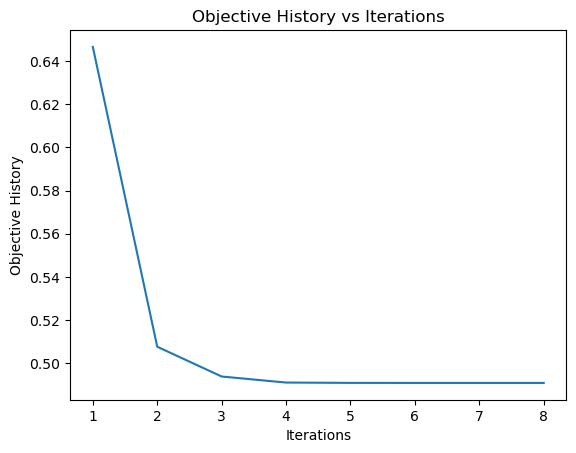

In [157]:
# Get the objective history from the lr_model summary
objective_history = lr_model.summary.objectiveHistory

# Create a list of iterations
iterations = list(range(1, len(objective_history) + 1))

plt.plot(iterations, objective_history)
plt.xlabel('Iterations')
plt.ylabel('Objective History')
plt.title('Objective History vs Iterations')
plt.show()